# Analysis - Payment Fraud (Empowering Financial Security)

**Descrição**: O conjunto de dados contém, aproximadamente 38k de transações de e-commerce anotados  
como _legítimo_ ou potencialmente _fraudulento_. Um conjunto compacto de features (8 colunas)  
permitem experimentação rápida com modelos tradicionais de ML, tree ensembles ou redes tabulares profundas.

1. __Linhas__: 38.662
2. __Colunas__: 8 -> (6 numéricos / 1 categórico / 1 binário)
3. __Tarefa__: Classificação binária

> Features:
> * __accountAgeDays__: Dias desde que a conta do cliente foi criada
> * __numItems__: Número de itens no carrinho
> * __LocalTime__: Hora local da transação
> * __paymentMethod__: Instrumento de pagamento (método)
> * __paymentMethodAgeDays__: Dias desde que o método de pagamento foi linkado à conta
> * __isWeekend__: Bandeira para semana (1 = positivo para semana, 0 = negativo para semana)
> * __Category__: Categoria de produto
> * __Label__: **Target** - 0 = legítimo, 1 = fraude

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import warnings
from datetime import datetime
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix
from imblearn.over_sampling import SMOTE # Balanceamento de classes -> Recomendação somente para datasets desbalanceados

In [2]:
warnings.filterwarnings('ignore')
print(f'Inicio: {str(datetime.now().strftime('%Y-%m-%d'))}')

Inicio: 2025-08-13


In [3]:
FOLDER_NAME = os.path.basename('csv files')
FILE_NAME = 'payment_fraud.csv'
exists = False

if os.path.exists(FOLDER_NAME):
    full_file = os.path.join(FOLDER_NAME, FILE_NAME)
    exists = f'{True}'
else:
    new_path = os.makedirs('csv_files')
    print(f'{exists}')

In [4]:
df = pd.read_csv(
    full_file, 
    encoding='utf-8', 
    thousands='|',
    na_filter=False, 
    verbose=0, 
    float_precision='legacy',
    skip_blank_lines=1
).rename(columns={
    'accountAgeDays': 'account_age_days',
    'numItems': 'num_items',
    'paymentMethod': 'payment_method',
    'paymentMethodAgeDays': 'payment_method_age_days'
})

df.iloc[1:5]

,account_age_days,num_items,localTime,payment_method,payment_method_age_days,Category,isWeekend,label
1,725,1,4.742303,storecredit,0.0,electronics,0,0
2,845,1,4.921318,creditcard,0.0,food,1,0
3,503,1,4.886641,creditcard,0.0,electronics,1,0
4,2000,1,5.040929,creditcard,0.0,shopping,0,0


In [5]:
df.info()
print(f'\n\nFormato: {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account_age_days         39221 non-null  int64  
 1   num_items                39221 non-null  int64  
 2   localTime                39221 non-null  float64
 3   payment_method           39221 non-null  object 
 4   payment_method_age_days  39221 non-null  float64
 5   Category                 39221 non-null  object 
 6   isWeekend                39221 non-null  object 
 7   label                    39221 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 2.4+ MB


Formato: (39221, 8)


In [6]:
from typing import Optional, Union, Dict
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def check_na_features(
    data:pd.DataFrame,
    show:bool=True,
    return_as:str='dict',
    log:bool=False
) -> Optional[Union[Dict[str, dict], pd.Series]]:
    
    na_cols = [cname for cname in data.columns if np.count_nonzero(data.isna().sum()) > 0]

    if not na_cols:
        message = f'No null columns encountered'
        if log:
            logger.info(message)
        elif show:
            print(message)
        return None

    message = f'Null columns found:\n {na_cols}'

    if log:
        logger.warning(message)
    elif show:
        print(message)

    if return_as == 'dict':
        return na_cols.to_dict()
    elif return_as == 'series':
        return na_cols
    else:
        raise ValueError("Parâmetro 'return_as' deve ser 'dict' ou 'series'")

In [7]:
outcome = check_na_features(df, True, 'series', False)

No null columns encountered


In [8]:
df.info()
print(f'\n\nFormato: {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account_age_days         39221 non-null  int64  
 1   num_items                39221 non-null  int64  
 2   localTime                39221 non-null  float64
 3   payment_method           39221 non-null  object 
 4   payment_method_age_days  39221 non-null  float64
 5   Category                 39221 non-null  object 
 6   isWeekend                39221 non-null  object 
 7   label                    39221 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 2.4+ MB


Formato: (39221, 8)


In [9]:
def is_duplicate(df): # Unused
    duplicates = []
    for i in df.index:
        row_i = df.loc[i]
        
        if i in duplicates:
            continue

        for j in df.index[df.index > i]:
            row_j = df.loc[j]
            if (row_i == row_j).all():
                duplicates.append(j)

    df = df.drop(index=duplicates)
    return df

In [10]:
df.duplicated().sum()

3033

In [11]:
df.drop_duplicates(keep='first', inplace=True)

In [12]:
df['Category'].value_counts()

Category
shopping       12339
food           11945
electronics    11809
                  95
Name: count, dtype: int64

In [13]:
df['payment_method'].value_counts()

payment_method
creditcard     25545
paypal          8772
storecredit     1871
Name: count, dtype: int64

In [14]:
df['label'].value_counts()

label
0    35792
1      396
Name: count, dtype: int64

## Checagem de classes desbalanceadas

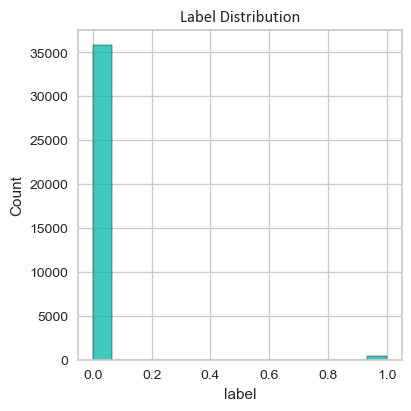

In [15]:
fig, ax = plt.subplots(figsize=(4, 4), layout='constrained')
ax = sns.histplot(df['label'].values, bins=15, stat='count', color='#01B8AA')

ax.set_title(f'Label Distribution', fontsize=12, fontfamily='Calibri')
ax.set_xlabel(f'label')

plt.show()

In [16]:
# Transformar os atributos categóricos em numéricos
from sklearn.preprocessing import FunctionTransformer

def convert_label_to_numeric(df:pd.DataFrame, predictor_cols:list):
    df_copy = df.copy()
    for cname in predictor_cols:
        if cname in ['payment_method', 'Category', 'isWeekend']:
            le = LabelEncoder()
            df_copy[cname] = le.fit_transform(df_copy[cname].astype(str))

    return df_copy

In [17]:
under_smp = int(len(df.iloc[:df.shape[0]]) * 0.3)
c_rnd= np.random.choice(np.arange(42), size=1, replace=True)

pred_cols = [c for c in df.columns if c != 'label']

In [18]:
label_transformer = FunctionTransformer(
    func=convert_label_to_numeric, 
    validate=False,
    kw_args={'predictor_cols': pred_cols}
)

In [19]:
df = label_transformer.fit_transform(df)

In [20]:
x = df.loc[:, pred_cols]
y = df['label'].values

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=c_rnd[0])

In [21]:
smote = SMOTE(sampling_strategy=0.7, random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [22]:
f = RandomForestClassifier(n_estimators=100)

In [23]:
# Seleção de hiperparâmetros
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [24]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=f, param_distributions=params, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='accuracy')

In [25]:
final_model = random_search.best_estimator_

In [26]:
y_pred = final_model.predict(x_test)
y_pred_proba = final_model.predict_proba(x_test)[:, 1]

In [27]:
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

AUC score: 1.0
f1 score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10731
           1       1.00      1.00      1.00       126

    accuracy                           1.00     10857
   macro avg       1.00      1.00      1.00     10857
weighted avg       1.00      1.00      1.00     10857

